# Notebooks
This section contains the the code for AirQuality Prediction.


In [1]:
import csv
import sqlite3

# File path to the dataset
data_path = "updated_pollution_dataset.csv"

# Step 1: Normalize the dataset
locations = {}
measurements = {}
location_id_counter = 1
measurement_id_counter = 1
link_table = []

# Read the CSV file and normalize data
with open(data_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Create Location Table
        location_tuple = (row["Proximity_to_Industrial_Areas"], row["Population_Density"])
        if location_tuple not in locations:
            locations[location_tuple] = location_id_counter
            location_id_counter += 1
        location_id = locations[location_tuple]

        # Create Air Quality Table
        measurement_tuple = (
            row["Temperature"], row["Humidity"], row["PM2.5"], row["PM10"],
            row["NO2"], row["SO2"], row["CO"], row["Air Quality"]
        )
        if measurement_tuple not in measurements:
            measurements[measurement_tuple] = measurement_id_counter
            measurement_id_counter += 1
        measurement_id = measurements[measurement_tuple]

        # Add to Link Table
        link_table.append((location_id, measurement_id))

# Save normalized tables to SQLite
try:
    with sqlite3.connect("pollution_data_normalized.db") as conn:
        cursor = conn.cursor()

        # Location Table
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS Location (
                Location_ID INTEGER PRIMARY KEY,
                Proximity_to_Industrial_Areas REAL,
                Population_Density REAL
            )
        """)
        for location, loc_id in locations.items():
            cursor.execute("""
                INSERT INTO Location (Location_ID, Proximity_to_Industrial_Areas, Population_Density)
                VALUES (?, ?, ?)
            """, (loc_id, location[0], location[1]))

        # Air Quality Table
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS AirQuality (
                Measurement_ID INTEGER PRIMARY KEY,
                Temperature REAL,
                Humidity REAL,
                PM2_5 REAL,
                PM10 REAL,
                NO2 REAL,
                SO2 REAL,
                CO REAL,
                Air_Quality TEXT
            )
        """)
        for measurement, meas_id in measurements.items():
            cursor.execute("""
                INSERT INTO AirQuality (Measurement_ID, Temperature, Humidity, PM2_5, PM10, NO2, SO2, CO, Air_Quality)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (meas_id, *measurement))

        # LocationAirQuality Link Table
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS LocationAirQuality (
                Location_ID INTEGER,
                Measurement_ID INTEGER,
                PRIMARY KEY (Location_ID, Measurement_ID),
                FOREIGN KEY (Location_ID) REFERENCES Location(Location_ID),
                FOREIGN KEY (Measurement_ID) REFERENCES AirQuality(Measurement_ID)
            )
        """)
        cursor.executemany("""
            INSERT INTO LocationAirQuality (Location_ID, Measurement_ID)
            VALUES (?, ?)
        """, link_table)

        conn.commit()
        print("Normalized database created successfully!")
except sqlite3.Error as e:
    print(f"An error occurred while creating the database: {e}")


Normalized database created successfully!


In [48]:
#Step-3
import sqlite3
import pandas as pd

# Define the SQL query to join normalized tables and fetch data
query = """
SELECT 
    loc.Proximity_to_Industrial_Areas, 
    loc.Population_Density, 
    air.Temperature, 
    air.Humidity, 
    air.PM2_5 AS PM2_5, 
    air.PM10 AS PM10, 
    air.NO2, 
    air.SO2, 
    air.CO, 
    air.Air_Quality
FROM 
    LocationAirQuality AS link
JOIN 
    Location AS loc ON link.Location_ID = loc.Location_ID
JOIN 
    AirQuality AS air ON link.Measurement_ID = air.Measurement_ID;
"""

# Connect to the SQLite database and fetch data
try:
    with sqlite3.connect("pollution_data_normalized.db") as conn:
        # Execute the query and load the result into a Pandas DataFrame
        data = pd.read_sql_query(query, conn)
        print("Data successfully fetched and loaded into a Pandas DataFrame.")
        print(data.head())  # Display the first few rows of the DataFrame
        
        # Save the data to a CSV file for downstream steps
        data.to_csv("data_from_step_2.csv", index=False)
        print("Data saved to 'data_from_step_2.csv'.")
except sqlite3.Error as e:
    print(f"An error occurred while fetching data: {e}")
smpl = pd.read_csv("data_from_step_2.csv")

Data successfully fetched and loaded into a Pandas DataFrame.
   Proximity_to_Industrial_Areas  Population_Density  Temperature  Humidity  \
0                            6.3               319.0         29.8      59.1   
1                            6.0               611.0         28.3      75.6   
2                            5.2               619.0         23.1      74.7   
3                           11.1               551.0         27.1      39.1   
4                           12.7               303.0         26.5      70.7   

   PM2_5  PM10   NO2   SO2    CO Air_Quality  
0    5.2  17.9  18.9   9.2  1.72    Moderate  
1    2.3  12.2  30.8   9.7  1.64    Moderate  
2   26.7  33.8  24.4  12.6  1.63    Moderate  
3    6.1   6.3  13.5   5.3  1.15        Good  
4    6.9  16.0  21.9   5.6  1.01        Good  
Data saved to 'data_from_step_2.csv'.


First few rows of the dataset:


,Proximity_to_Industrial_Areas,Population_Density,Temperature,Humidity,PM2_5,PM10,NO2,SO2,CO,Air_Quality
0,6.3,319.0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,Moderate
1,6.0,611.0,28.3,75.6,2.3,12.2,30.8,9.7,1.64,Moderate
2,5.2,619.0,23.1,74.7,26.7,33.8,24.4,12.6,1.63,Moderate
3,11.1,551.0,27.1,39.1,6.1,6.3,13.5,5.3,1.15,Good
4,12.7,303.0,26.5,70.7,6.9,16.0,21.9,5.6,1.01,Good



Distribution of the target variable:
Air_Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64


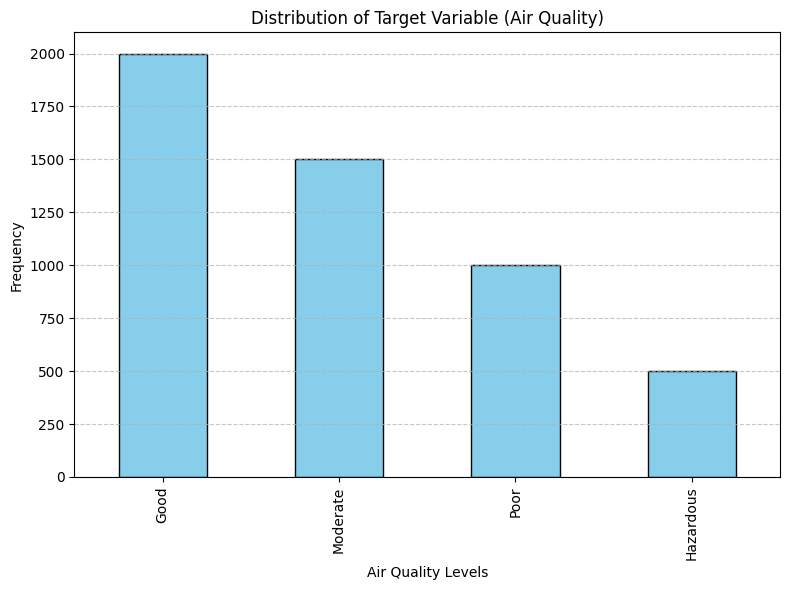


Class distribution in the entire dataset (as percentages):
Air_Quality
Good         0.4
Moderate     0.3
Poor         0.2
Hazardous    0.1
Name: proportion, dtype: float64

Class distribution in the training set:
Air_Quality
Good         0.4
Moderate     0.3
Poor         0.2
Hazardous    0.1
Name: proportion, dtype: float64

Class distribution in the testing set:
Air_Quality
Good         0.4
Moderate     0.3
Poor         0.2
Hazardous    0.1
Name: proportion, dtype: float64


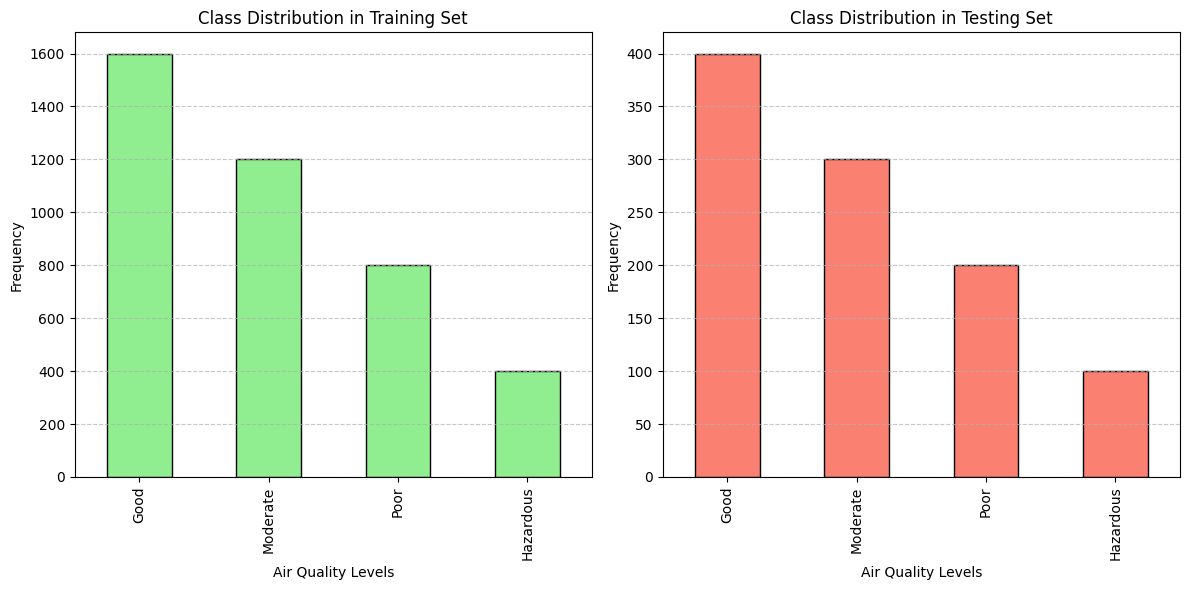

In [3]:
#step-3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the data from Step-2
data = pd.read_csv("data_from_step_2.csv")  # Replace with the correct file name if different

# Display the first few rows of the data
print("First few rows of the dataset:")
display(data.head())

# Explore the class distribution of the target variable
target_column = "Air_Quality"  # Ensure this matches your target variable name
print("\nDistribution of the target variable:")
print(data[target_column].value_counts())

# Plot the class distribution
plt.figure(figsize=(8, 6))
data[target_column].value_counts().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Target Variable (Air Quality)")
plt.xlabel("Air Quality Levels")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Check if stratification is needed
class_distribution = data[target_column].value_counts(normalize=True)
print("\nClass distribution in the entire dataset (as percentages):")
print(class_distribution)

# Stratified train/test split
X = data.drop(columns=[target_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verify the stratification
print("\nClass distribution in the training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in the testing set:")
print(y_test.value_counts(normalize=True))

# Display EDA output to confirm consistency
plt.figure(figsize=(12, 6))

# Plot training set distribution
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Class Distribution in Training Set")
plt.xlabel("Air Quality Levels")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Plot testing set distribution
plt.subplot(1, 2, 2)
y_test.value_counts().plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Class Distribution in Testing Set")
plt.xlabel("Air Quality Levels")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
!pip install ydata-profiling
!pip install matplotlib seaborn
!pip install pandas
!pip install numpy
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

First few rows of the dataset:


,Proximity_to_Industrial_Areas,Population_Density,Temperature,Humidity,PM2_5,PM10,NO2,SO2,CO,Air_Quality
0,6.3,319.0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,Moderate
1,6.0,611.0,28.3,75.6,2.3,12.2,30.8,9.7,1.64,Moderate
2,5.2,619.0,23.1,74.7,26.7,33.8,24.4,12.6,1.63,Moderate
3,11.1,551.0,27.1,39.1,6.1,6.3,13.5,5.3,1.15,Good
4,12.7,303.0,26.5,70.7,6.9,16.0,21.9,5.6,1.01,Good


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]


Missing Values in Each Column:
Proximity_to_Industrial_Areas    0
Population_Density               0
Temperature                      0
Humidity                         0
PM2_5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Air_Quality                      0
dtype: int64


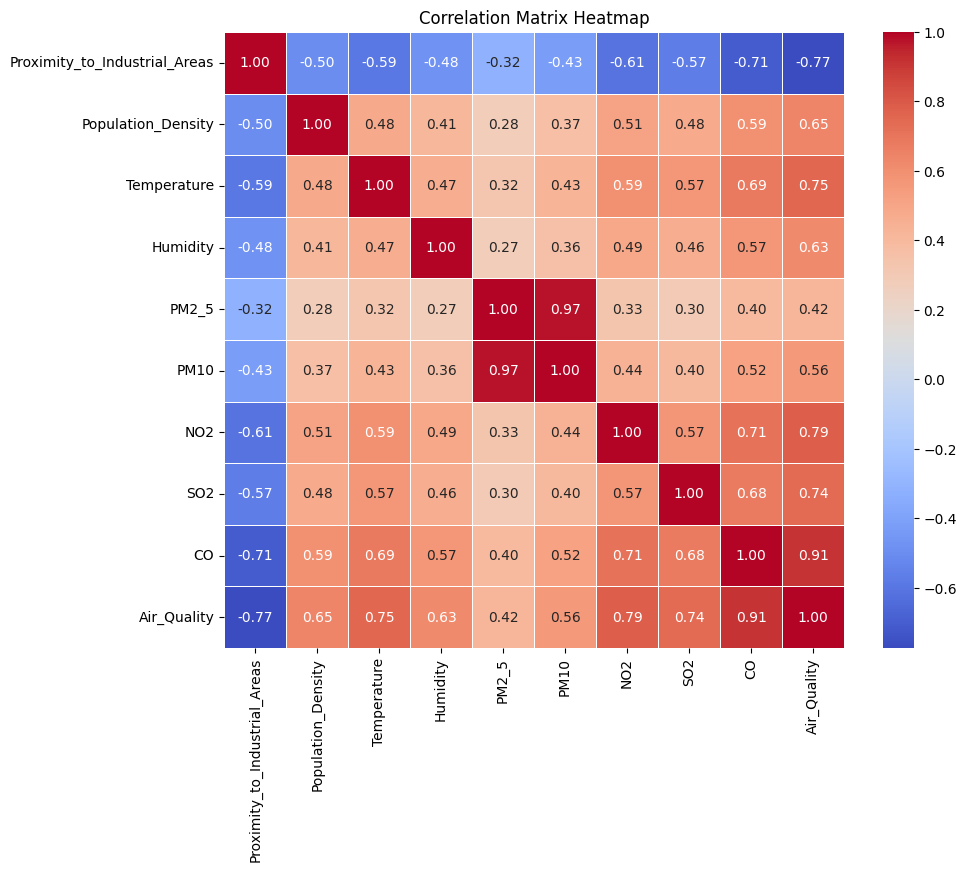


Observations:
- Check for high correlations (e.g., PM2.5 and PM10).
- Identify missing values in certain columns.
- Check if distributions of features like CO or SO2 are skewed or capped.

Data Cleanup Tasks:
1. Handle missing values in columns with non-zero missing counts.
2. Normalize features with high variance.
3. Remove highly correlated features to avoid multicollinearity.
4. Check for outliers and skewness in pollutant data (e.g., CO, PM2.5).
5. Encode categorical variables (if any).
6. Ensure the target variable has consistent formatting.


In [5]:
#step-4
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
data = pd.read_csv("data_from_step_2.csv")
print("First few rows of the dataset:")
display(data.head())
air_quality_mapping = {"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3}
data["Air_Quality"] = data["Air_Quality"].map(air_quality_mapping)
profile = ProfileReport(data, title="Data Profiling Report", explorative=True)
profile.to_widgets()
print("\nMissing Values in Each Column:")
print(data.isnull().sum())
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.savefig("correlation_matrix.png")
plt.show()
print("\nObservations:")
print("- Check for high correlations (e.g., PM2.5 and PM10).")
print("- Identify missing values in certain columns.")
print("- Check if distributions of features like CO or SO2 are skewed or capped.")
cleanup_tasks = [
    "Handle missing values in columns with non-zero missing counts.",
    "Normalize features with high variance.",
    "Remove highly correlated features to avoid multicollinearity.",
    "Check for outliers and skewness in pollutant data (e.g., CO, PM2.5).",
    "Encode categorical variables (if any).",
    "Ensure the target variable has consistent formatting."
]

print("\nData Cleanup Tasks:")
for i, task in enumerate(cleanup_tasks, 1):
    print(f"{i}. {task}")


In [ ]:
!pip install dagshub mlflow

In [7]:

import dagshub
dagshub.init(repo_owner='saket027', repo_name='EAS_503_Updated_Air_Quality_Prediction', mlflow=True)

Accessing as saket027

Initialized MLflow to track repo "saket027/EAS_503_Updated_Air_Quality_Prediction"

Repository saket027/EAS_503_Updated_Air_Quality_Prediction initialized!

In [15]:
#step-5
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow
import mlflow.sklearn
data = pd.read_csv("data_from_step_2.csv")
X = data.drop(columns=["Air_Quality"])
y = data["Air_Quality"].map({"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3})
numerical_features = X.select_dtypes(include=["float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numerical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log", FunctionTransformer(np.log1p, validate=True))
])

categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define the Logistic Regression pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Define custom scoring metrics
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_micro": make_scorer(f1_score, average="micro")
}

# Configure MLflow with your DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Experiment_1_logistic_regression")

with mlflow.start_run():
    # Perform cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=True)

    # Log F1-scores to MLflow
    mlflow.log_metric("f1_macro_mean", np.mean(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_macro_std", np.std(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_micro_mean", np.mean(cv_results["test_f1_micro"]))
    mlflow.log_metric("f1_micro_std", np.std(cv_results["test_f1_micro"]))

    # Fit the pipeline on the full training data
    pipeline.fit(X, y)

    # Log confusion matrix on the full training data
    y_pred = pipeline.predict(X)
    cm = confusion_matrix(y, y_pred, labels=[0, 1, 2, 3])
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)

    # Hyperparameter tuning
    param_grid = {
        "classifier__C": [0.1, 1.0, 10.0],  # Example regularization parameters
        "classifier__solver": ["lbfgs", "liblinear"]
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
    grid_search.fit(X, y)

    # Log hyperparameter tuning results
    mlflow.log_param("best_C", grid_search.best_params_["classifier__C"])
    mlflow.log_param("best_solver", grid_search.best_params_["classifier__solver"])
    mlflow.log_metric("best_f1_macro", grid_search.best_score_)

    # Log the model
    mlflow.sklearn.log_model(grid_search.best_estimator_, "logistic_regression_pipeline")
    print("Experiment logged in MLflow.")


2024/12/19 17:12:44 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_1_logistic_regression' does not exist. Creating a new experiment.
2024/12/19 17:12:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment logged in MLflow.
🏃 View run gentle-grouse-618 at: https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow/#/experiments/1/runs/faf22efcff0648cab4340a0fa08119cb
🧪 View experiment at: https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow/#/experiments/1


In [ ]:
pip install xgboost

In [ ]:
#Experiment-2
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Load the dataset
data = pd.read_csv("data_from_step_2.csv")  # Replace with your actual file name

# Separate features and target
X = data.drop(columns=["Air_Quality"])  # Replace with your target variable name if different
y = data["Air_Quality"].map({"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3})

# Define preprocessing pipeline
numerical_features = X.select_dtypes(include=["float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numerical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log", FunctionTransformer(np.log1p, validate=True))  # Log transformation
])

categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    # Remove deprecated parameter use_label_encoder
    "XGBClassifier": XGBClassifier(eval_metric="mlogloss", random_state=42)
}

# Configure MLflow with your DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("experiment_2_multiple_classifiers")

# Scoring
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_micro": make_scorer(f1_score, average="micro")
}

# We will use a single sample from X to infer model signature and provide input_example
input_example = X.iloc[[0]]

for name, classifier in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create a pipeline with the current classifier
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", classifier)
        ])

        # Perform cross-validation
        cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=True)

        # Log metrics
        mlflow.log_metric("f1_macro_mean", np.mean(cv_results["test_f1_macro"]))
        mlflow.log_metric("f1_macro_std", np.std(cv_results["test_f1_macro"]))
        mlflow.log_metric("f1_micro_mean", np.mean(cv_results["test_f1_micro"]))
        mlflow.log_metric("f1_micro_std", np.std(cv_results["test_f1_micro"]))

        # Fit the pipeline on the full dataset to log the model
        pipeline.fit(X, y)

        # Infer model signature
        signature = infer_signature(input_example, pipeline.predict(input_example))

        # Log the model with input_example and signature
        mlflow.sklearn.log_model(
            pipeline, 
            artifact_path=f"{name}_pipeline",
            input_example=input_example, 
            signature=signature
        )
        print(f"Experiment for {name} logged in MLflow with signature and input example.")


In [ ]:
#Experiment-3
import os
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Load the dataset
data = pd.read_csv("data_from_step_2.csv")  # Replace with the actual file name

# Separate features and target
X = data.drop(columns=["Air_Quality"])  # Replace with your target column if different
y = data["Air_Quality"].map({"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3})

# Define a custom transformer for feature engineering
# Example: Create new features like PM_Ratio = PM2.5 / (PM10+1), NO2_SO2_Ratio = NO2/(SO2+1), 
# and an interaction feature like Temp_Humidity = Temperature * Humidity.
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Ensure columns exist before creating ratios
        if "PM2.5" in X.columns and "PM10" in X.columns:
            X["PM_Ratio"] = X["PM2.5"] / (X["PM10"] + 1e-9)  # Avoid division by zero
        
        if "NO2" in X.columns and "SO2" in X.columns:
            X["NO2_SO2_Ratio"] = X["NO2"] / (X["SO2"] + 1e-9)
        
        if "Temperature" in X.columns and "Humidity" in X.columns:
            X["Temperature_Humidity"] = X["Temperature"] * X["Humidity"]
        
        return X

# Identify numerical and categorical features after original data loaded
numerical_features = X.select_dtypes(include=["float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Numerical preprocessing pipeline
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log", FunctionTransformer(np.log1p, validate=True))
])

# Categorical preprocessing pipeline
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Combine feature engineering and preprocessing into one pipeline
pipeline = Pipeline([
    ("feature_engineering", FeatureEngineering()),
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Define scoring
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_micro": make_scorer(f1_score, average="micro")
}

# Configure MLflow with your DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("experiment_3_feature_engineering")

with mlflow.start_run():
    # Perform cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=True)

    # Log metrics
    mlflow.log_metric("f1_macro_mean", np.mean(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_macro_std", np.std(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_micro_mean", np.mean(cv_results["test_f1_micro"]))
    mlflow.log_metric("f1_micro_std", np.std(cv_results["test_f1_micro"]))

    # Fit the pipeline on the full dataset to log the model
    pipeline.fit(X, y)

    # Create a single-row input example for signature inference
    input_example = X.iloc[[0]]
    signature = infer_signature(input_example, pipeline.predict(input_example))

    # Log the model
    mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="feature_engineered_pipeline",
        input_example=input_example, 
        signature=signature
    )
    print("Experiment #3 logged in MLflow with feature engineering.")


In [ ]:
#Experiment-4
import os
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Custom transformer to remove correlated features
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.features_to_drop_ = []
    
    def fit(self, X, y=None):
        # Calculate correlation matrix
        corr_matrix = pd.DataFrame(X).corr().abs()
        
        # Upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find features to drop
        self.features_to_drop_ = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X).drop(columns=self.features_to_drop_, errors='ignore')
        return X.values

# Load the dataset
data = pd.read_csv("data_from_step_2.csv")  # Replace with your actual file name

# Separate features and target
X = data.drop(columns=["Air_Quality"])  # Replace if target differs
y = data["Air_Quality"].map({"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3})

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=["float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Numerical preprocessing pipeline
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log", FunctionTransformer(np.log1p, validate=True))
])

# Categorical preprocessing pipeline
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Feature selection steps:
# 1. VarianceThreshold
# 2. CorrelationFilter (custom transformer)
# 3. SelectFromModel (RandomForest) for feature importance
feature_selection = Pipeline([
    ("var_thresh", VarianceThreshold(threshold=0.0)),
    ("corr_filter", CorrelationFilter(threshold=0.9)),
    ("importance", SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median"))
])

# Final pipeline with Logistic Regression
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selection", feature_selection),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

# Scoring
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_micro": make_scorer(f1_score, average="micro")
}

# Configure MLflow with DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("experiment_4_feature_selection")

with mlflow.start_run():
    # Perform cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=True)

    # Log metrics
    mlflow.log_metric("f1_macro_mean", np.mean(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_macro_std", np.std(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_micro_mean", np.mean(cv_results["test_f1_micro"]))
    mlflow.log_metric("f1_micro_std", np.std(cv_results["test_f1_micro"]))

    # Fit the pipeline on full data to log the model
    pipeline.fit(X, y)

    # Create an input example for model signature
    input_example = X.iloc[[0]]
    signature = infer_signature(input_example, pipeline.predict(input_example))

    # Log the model with signature and input example
    mlflow.sklearn.log_model(
        pipeline,
        artifact_path="feature_selection_pipeline",
        input_example=input_example,
        signature=signature
    )
    print("Experiment #4 logged in MLflow with feature selection steps.")


2024/12/19 17:55:32 INFO mlflow.tracking.fluent: Experiment with name 'experiment_5_pca' does not exist. Creating a new experiment.


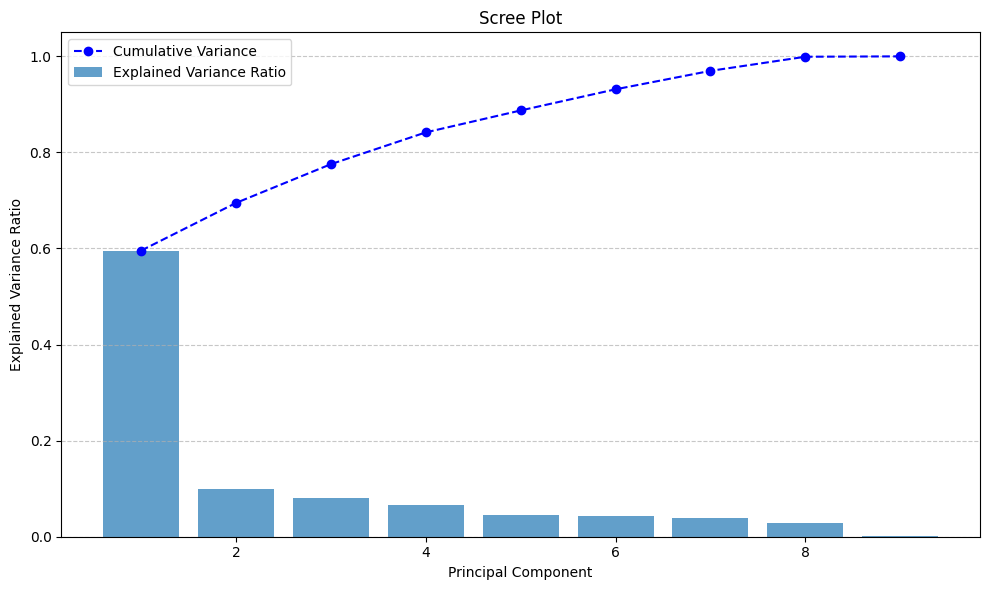

Experiment #5 logged in MLflow. PCA chose 7 components.
🏃 View run sassy-roo-165 at: https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow/#/experiments/5/runs/e57a9ec863ff4bbb9d33a6fd1f59aa71
🧪 View experiment at: https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow/#/experiments/5


In [23]:
#Experiment-5
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Load the dataset
data = pd.read_csv("data_from_step_2.csv")  # Replace with the correct file name

# Separate features and target
X = data.drop(columns=["Air_Quality"])  # Adjust if target differs
y = data["Air_Quality"].map({"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3})

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=["float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Numerical pipeline
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log", FunctionTransformer(np.log1p, validate=True))
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Configure MLflow with your DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("experiment_5_pca")

with mlflow.start_run():
    # Preprocess the data to fit PCA
    X_pre = preprocessor.fit_transform(X)

    # Fit PCA to determine explained variance
    pca_full = PCA()
    pca_full.fit(X_pre)
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Create scree plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--', color='b', label='Cumulative Variance')
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Explained Variance Ratio')
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    # Save and show the scree plot inline
    plt.savefig("scree_plot.png")
    plt.show()
    mlflow.log_artifact("scree_plot.png")

    # Select number of components that explain at least 95% variance
    n_components = np.argmax(cumulative_variance >= 0.95) + 1

    # Create a pipeline with PCA using selected components
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=n_components, random_state=42)),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Scoring metrics
    scoring = {
        "f1_macro": make_scorer(f1_score, average="macro"),
        "f1_micro": make_scorer(f1_score, average="micro")
    }

    # Perform cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=True)

    # Log metrics
    mlflow.log_metric("f1_macro_mean", np.mean(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_macro_std", np.std(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_micro_mean", np.mean(cv_results["test_f1_micro"]))
    mlflow.log_metric("f1_micro_std", np.std(cv_results["test_f1_micro"]))

    # Fit pipeline on entire dataset
    pipeline.fit(X, y)

    # Create input_example and signature
    input_example = X.iloc[[0]]
    signature = infer_signature(input_example, pipeline.predict(input_example))

    # Log the model with MLflow
    mlflow.sklearn.log_model(
        pipeline,
        artifact_path="pca_pipeline",
        input_example=input_example,
        signature=signature
    )
    mlflow.log_param("n_components", n_components)

    print(f"Experiment #5 logged in MLflow. PCA chose {n_components} components.")


In [ ]:
#Eperiment-6

import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Load data
data = pd.read_csv("data_from_step_2.csv")  # Replace with your actual file name

# Separate features and target
X = data.drop(columns=["Air_Quality"])  # Adjust if target differs
y = data["Air_Quality"].map({"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3})

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=["float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Numerical pipeline
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log", FunctionTransformer(np.log1p, validate=True)),  # Log transform
    ("poly", PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Define the classifier (Custom choice: GradientBoostingClassifier)
classifier_GradientBoosting = GradientBoostingClassifier(random_state=42)

# Full pipeline
gb_classifier = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", classifier_GradientBoosting)
])

# Scoring
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_micro": make_scorer(f1_score, average="micro")
}

# Configure MLflow with DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("Experiment_6_custom")

with mlflow.start_run():
    # Perform cross-validation
    cv_results = cross_validate(gb_classifier, X, y, cv=10, scoring=scoring, return_train_score=True)

    # Log metrics
    mlflow.log_metric("f1_macro_mean", np.mean(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_macro_std", np.std(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_micro_mean", np.mean(cv_results["test_f1_micro"]))
    mlflow.log_metric("f1_micro_std", np.std(cv_results["test_f1_micro"]))

    # Fit on full data
    gb_classifier.fit(X, y)

    # Create input_example and signature
    input_example = X.iloc[[0]]
    signature = infer_signature(input_example, gb_classifier.predict(input_example))

    # Log model
    mlflow.sklearn.log_model(
        gb_classifier,
        artifact_path="custom_experiment_pipeline",
        input_example=input_example,
        signature=signature
    )

    # Log parameters (e.g., polynomial degree)
    mlflow.log_param("polynomial_degree", 2)

    print("Experiment #6 (Custom) logged in MLflow.")


In [ ]:
pip install lightgbm


In [ ]:
#Experiment - 7
import os
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from lightgbm import LGBMClassifier

# Custom transformer for mutual information-based feature selection
class MutualInfoFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k=10, random_state=42):
        self.k = k
        self.random_state = random_state
        self.selected_indices_ = None

    def fit(self, X, y):
        # Compute mutual information between features and target
        mi_scores = mutual_info_classif(X, y, random_state=self.random_state)
        # Select top k features based on mutual information scores
        self.selected_indices_ = np.argsort(mi_scores)[-self.k:]
        return self

    def transform(self, X):
        return X[:, self.selected_indices_]

# Load the dataset from Step-2
data = pd.read_csv("data_from_step_2.csv")  # Replace with your actual file name

# Separate features and target
X = data.drop(columns=["Air_Quality"])  # Adjust if target differs
y = data["Air_Quality"].map({"Good": 0, "Moderate": 1, "Poor": 2, "Hazardous": 3})

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=["float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Numerical pipeline
numerical_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("minmax", MinMaxScaler()),
    ("log", FunctionTransformer(np.log1p, validate=True))
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Choose the number of features to select
K = 10

# Define scoring
scoring = {
    "f1_macro": make_scorer(f1_score, average="macro"),
    "f1_micro": make_scorer(f1_score, average="micro")
}

# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("feature_selector", MutualInfoFeatureSelector(k=K)),
    ("classifier", LGBMClassifier(random_state=42))
])

# Configure MLflow with DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("experiment_7_custom")

with mlflow.start_run():
    # Perform cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=10, scoring=scoring, return_train_score=True)

    # Log metrics
    mlflow.log_metric("f1_macro_mean", np.mean(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_macro_std", np.std(cv_results["test_f1_macro"]))
    mlflow.log_metric("f1_micro_mean", np.mean(cv_results["test_f1_micro"]))
    mlflow.log_metric("f1_micro_std", np.std(cv_results["test_f1_micro"]))

    # Fit on full data
    pipeline.fit(X, y)

    # Create input_example and signature
    input_example = X.iloc[[0]]
    prediction_example = pipeline.predict(input_example)
    signature = infer_signature(input_example, prediction_example)

    # Log model with MLflow
    mlflow.sklearn.log_model(
        pipeline,
        artifact_path="mutual_info_pipeline_lgbm",
        input_example=input_example,
        signature=signature
    )

    # Log parameters (e.g., K)
    mlflow.log_param("selected_features_k", K)

    print("Experiment #7 (Another Custom Experiment) logged in MLflow with mutual info feature selection and LGBMClassifier.")


Aggregated Results:


,Experiment,f1_macro_mean,f1_micro_mean
0,Experiment_1_logistic_regression,0.892077,0.9250
1,experiment_2_multiple_classifiers,0.933326,0.9554
2,experiment_3_feature_engineering,0.892077,0.9250
3,experiment_4_feature_selection,0.852230,0.8972
4,experiment_5_pca,0.889305,0.9218
5,Experiment_6_custom,0.933305,0.9558
6,experiment_7_custom,0.933196,0.9544


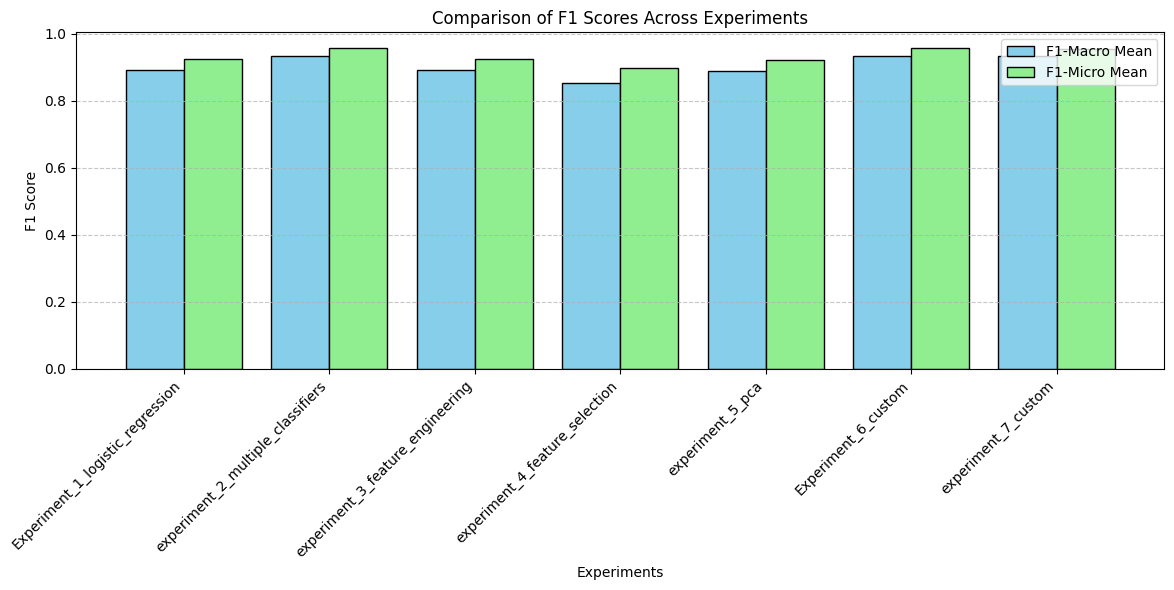

Best model by f1_macro_mean: experiment_2_multiple_classifiers
Best model by f1_micro_mean: Experiment_6_custom


In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

# Configure MLflow with your DagsHub credentials
MLFLOW_TRACKING_URI = "https://dagshub.com/saket027/EAS_503_Updated_Air_Quality_Prediction.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "saket027"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "553f4ee6bcede3c7f7f8eb2c08404b0ad4209b2e"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# List of experiment names (replace if needed)
experiment_names = [
    "Experiment_1_logistic_regression",
    "experiment_2_multiple_classifiers",
    "experiment_3_feature_engineering",
    "experiment_4_feature_selection",
    "experiment_5_pca",
    "Experiment_6_custom",
    "experiment_7_custom"
]

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=["Experiment", "f1_macro_mean", "f1_micro_mean"])

for exp_name in experiment_names:
    exp = mlflow.get_experiment_by_name(exp_name)
    if exp is None:
        print(f"Experiment '{exp_name}' not found. Skipping.")
        continue

    runs = mlflow.search_runs(experiment_ids=[exp.experiment_id])
    if runs.empty:
        print(f"No runs found for '{exp_name}'. Skipping.")
        continue

    # Check if metrics are present
    if "metrics.f1_macro_mean" not in runs.columns or "metrics.f1_micro_mean" not in runs.columns:
        print(f"'f1_macro_mean' or 'f1_micro_mean' not found for '{exp_name}'. Skipping.")
        continue

    # Convert to numeric
    runs["f1_macro_mean"] = pd.to_numeric(runs["metrics.f1_macro_mean"], errors='coerce')
    runs["f1_micro_mean"] = pd.to_numeric(runs["metrics.f1_micro_mean"], errors='coerce')

    if runs["f1_macro_mean"].isna().all() or runs["f1_micro_mean"].isna().all():
        print(f"No valid f1_macro_mean or f1_micro_mean for '{exp_name}'. Skipping.")
        continue

    # Select the best run by f1_macro_mean
    best_run_idx = runs["f1_macro_mean"].idxmax()
    best_run = runs.loc[best_run_idx]

    f1_macro_mean = best_run["f1_macro_mean"]
    f1_micro_mean = best_run["f1_micro_mean"]

    # Add the results to DataFrame
    results.loc[len(results)] = [exp_name, f1_macro_mean, f1_micro_mean]

# Check if we have any results
if results.empty:
    print("No experiments with valid runs found.")
else:
    print("Aggregated Results:")
    display(results)

    # Plot the F1-scores as a comparison bar chart
    plt.figure(figsize=(12, 6))
    bar_width = 0.4
    index = range(len(results))

    plt.bar(index, results["f1_macro_mean"], bar_width, color="skyblue", label="F1-Macro Mean", edgecolor="black")
    plt.bar([i + bar_width for i in index], results["f1_micro_mean"], bar_width, color="lightgreen", label="F1-Micro Mean", edgecolor="black")

    plt.xlabel("Experiments")
    plt.ylabel("F1 Score")
    plt.title("Comparison of F1 Scores Across Experiments")
    plt.xticks([i + bar_width/2 for i in index], results["Experiment"], rotation=45, ha="right")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Determine best model by each metric
    if not results["f1_macro_mean"].isna().all():
        best_f1_macro_experiment = results.loc[results["f1_macro_mean"].idxmax(), "Experiment"]
        print(f"Best model by f1_macro_mean: {best_f1_macro_experiment}")

    if not results["f1_micro_mean"].isna().all():
        best_f1_micro_experiment = results.loc[results["f1_micro_mean"].idxmax(), "Experiment"]
        print(f"Best model by f1_micro_mean: {best_f1_micro_experiment}")


In [54]:
import joblib

# Assuming 'pipeline' is your best model (already trained)
joblib.dump(gb_classifier, "gradient_boost_v1.pk1")
print("Best model from Experiment 6 saved")


Best model from Experiment 6 saved


In [55]:
final_model_reloaded = joblib.load("gradient_boost_v1.pk1")